In [1]:
import sys
sys.path.append('../src')

from module.module import Linear
from module.activation import TanH, Sigmoide, ReLU

from loss.loss import MSELoss
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.plots import plot_net, plot_reconstruction, classification_report, net_to_graph

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
seed = 42

In [4]:
np.random.seed(seed)

In [5]:
df = pd.read_csv("../data/ecg.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [6]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values.astype(int)

In [7]:
min_x = np.min(X)
max_x = np.max(X)

X = (X - min_x)/(max_x - min_x)

In [8]:
n_X = X[y == 1]

an_X = X[y == 0]

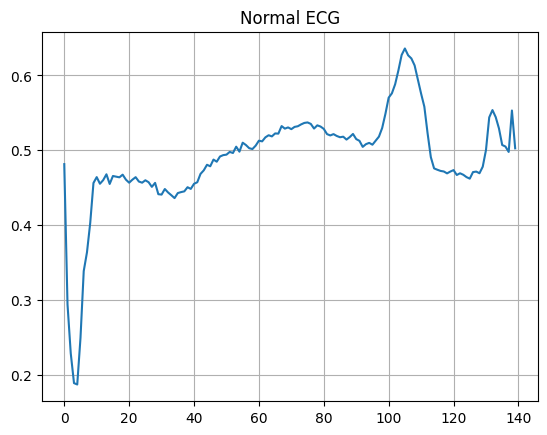

In [9]:
plt.plot(np.arange(140), n_X[0])
plt.grid()
plt.title('Normal ECG')
plt.show()

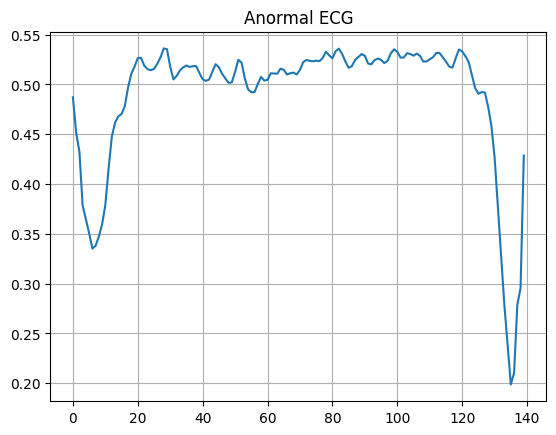

In [10]:
plt.plot(np.arange(140), an_X[0])
plt.grid()
plt.title('Anormal ECG')
plt.show()

100%|██████████| 500/500 [00:22<00:00, 21.79it/s]

Training completed.


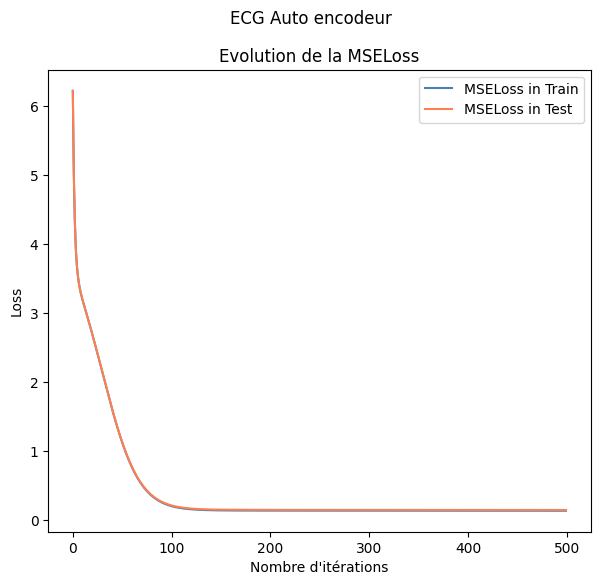

In [11]:

input_neurons = 140
h1 = 32
h2 = 16
h3 = 8

encoder = [
    Linear(input_neurons, h1, bias=True, init="uniform"),
    ReLU(),
    Linear(h1, h2, bias=True, init="uniform"),
    ReLU(),
    Linear(h2, h3, bias=True, init="uniform"),
    ReLU(),
]

decoder = [
    Linear(h3, h2, bias=True, init="uniform"),
    ReLU(),
    Linear(h2, h1, bias=True, init="uniform"),
    ReLU(),
    Linear(h1, input_neurons, bias=True, init="uniform"),
    Sigmoide()
]

net = Sequentiel([*encoder, *decoder], classes_type="0/1")

optim = Optim(net, MSELoss(), eps=1e-5)
optim.SGD(n_X, n_X, test_train_split=True, batch_size=512, epochs=500, verbose=False)

plot_net(optim, n_X, n_X, net_type="auto_encodeur", net_title="ECG Auto encodeur")

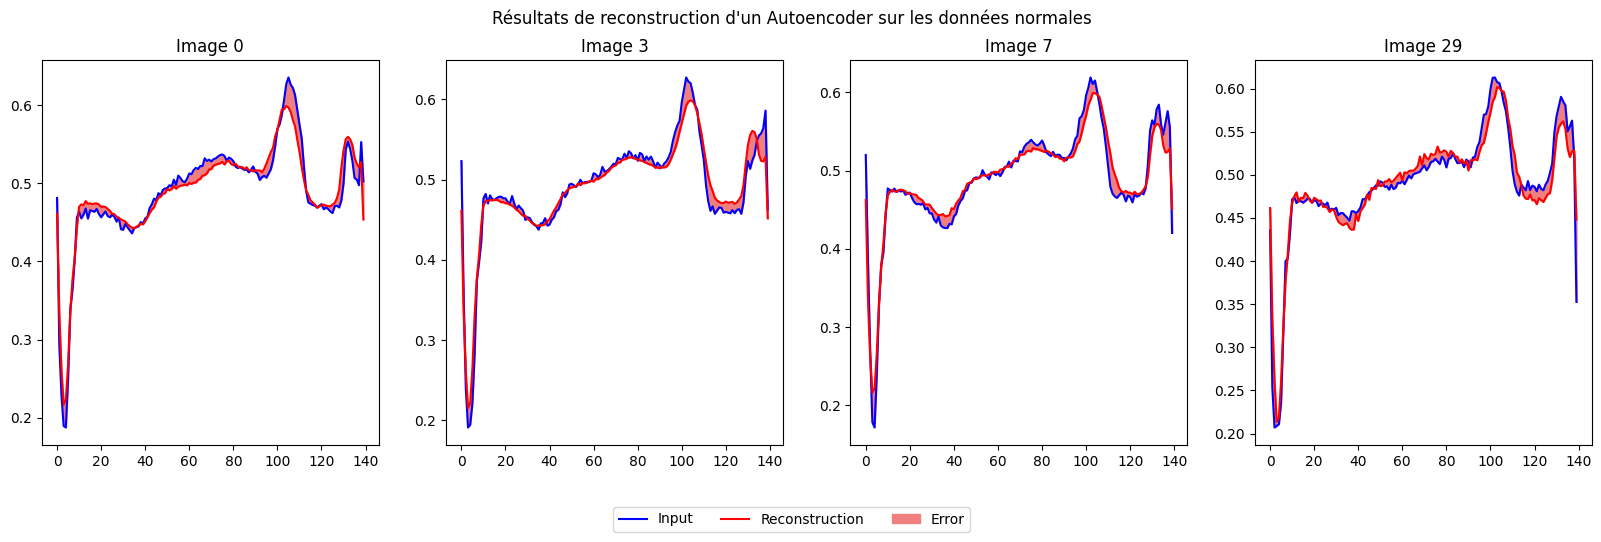

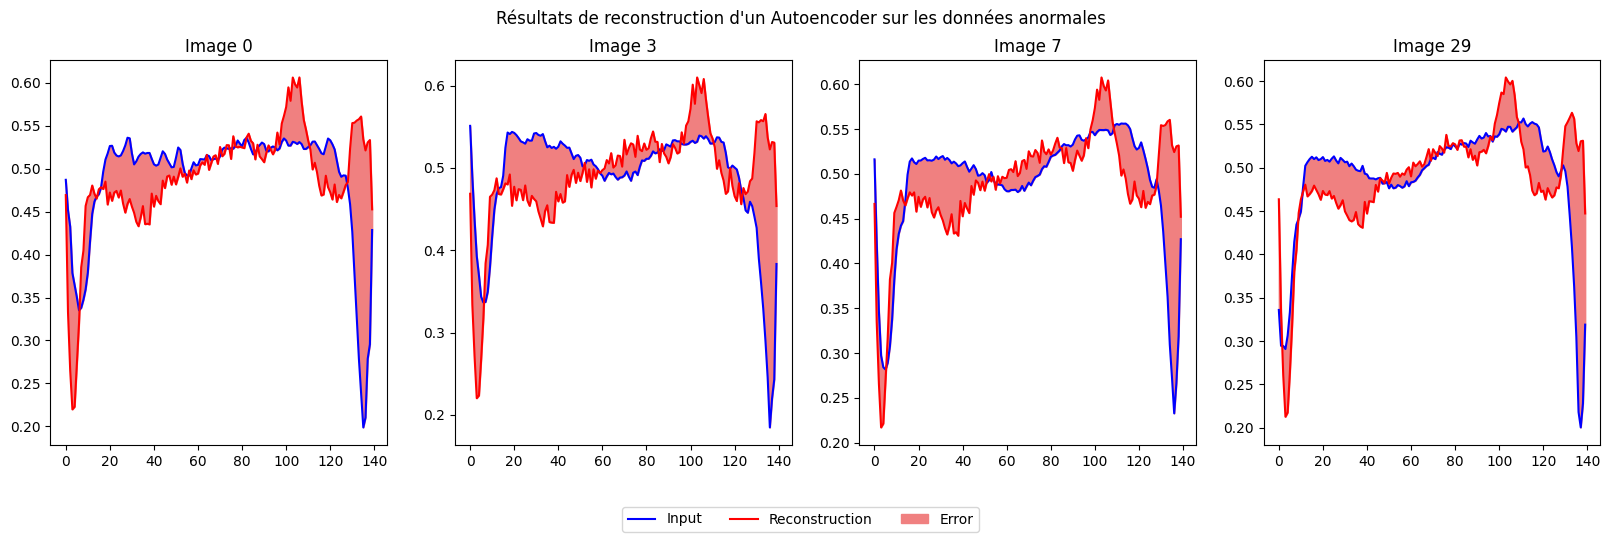

In [12]:
plot_reconstruction(net, n_X, [0, 3, 7, 29], "normales")
plot_reconstruction(net, an_X, [0, 3, 7, 29], "anormales")

In [13]:
reconstructed = net(n_X)
mse_train = np.mean(np.power(reconstructed - n_X, 2), axis=1)
t = np.mean(mse_train) + 2 * np.std(mse_train)
t

0.003371520338463129

In [14]:
def is_normal_data(model, data, threshold):
  rec = model(data)
  mse = np.mean(np.power(rec - data, 2), axis=1)
  
  return np.less(mse, threshold)

In [15]:
pred_n_X = is_normal_data(net, n_X, t)
pred_n_X.shape

(2919,)

In [16]:
pred_an_X = is_normal_data(net, an_X, t)
pred_an_X.shape

(2079,)

In [17]:
yhat = np.concatenate((pred_n_X, pred_an_X)).astype(int)
yhat.shape

(4998,)

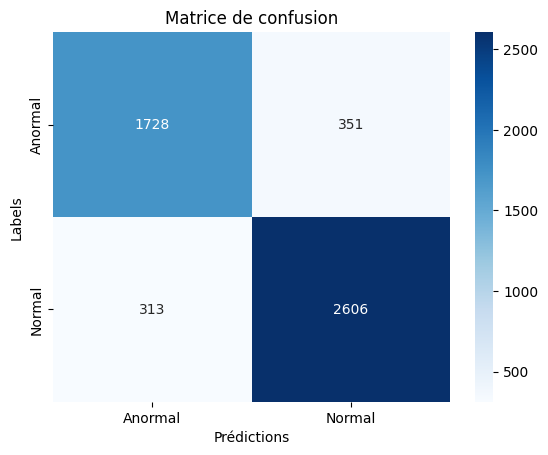

In [18]:
df = classification_report(y, yhat, ["Anormal", "Normal"])

In [19]:
print(df.to_latex(float_format="{:.1f}".format))

\begin{tabular}{lrllr}
\toprule
 & precision & recall & f1-score & support \\
class &  &  &  &  \\
\midrule
Anormal & 0.8 & 0.8 & 0.8 & 2079 \\
Normal & 0.9 & 0.9 & 0.9 & 2919 \\
accuracy & 0.9 &  &  & 4998 \\
\bottomrule
\end{tabular}



In [21]:
# net_to_graph(net = Sequentiel(encoder),net_name="4_coeurNetEncoder", horizontal=True)
# net_to_graph(net = Sequentiel(decoder),net_name="4_coeurNetDecoder", horizontal=True)
